In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import plotly.graph_objs as go
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
import matplotlib.patches as patches
import random
import re
from tabulate import tabulate
import exchange as e

## Danmarks produktion og forbrug samt surplus og EENS

In [2]:
#definerer et plot til senere brug
def plot(x_data, y_data, title=None, freq=None, start=None, end=None):
    """
    plot data med givne x og y værdier.

    Parametere:
        x_data (array or array-like): Data til x akse.
        y_data (array or array-like): Data til y akse.
        title (str): Title til plottet.
        freq (int): Dette er en multiplikator effekt. hvis den er sat til f.eks. 24 så summere den per 24 timer
        start (int): Start timen.
        end (int): Slut timen.
    """
    
    
    if freq is None:
        # Plot all data points
        plt.plot(x_data, y_data)
    else:
        # Resample y_data based on the specified frequency
        grouped_data = pd.DataFrame({'x': x_data, 'y': y_data}).set_index('x').resample(f"{freq}H").sum().reset_index()
        start_index = start // freq
        end_index = end // freq
        x = np.arange(len(grouped_data))[start_index:end_index]
        y = grouped_data['y'][start_index:end_index]
        plt.plot(x, y)
    
    plt.xlabel('Timer')
    plt.ylabel(y_data.name if hasattr(y_data, 'name') else 'MWh')
    plt.title(title if title else 'Dynamic Range Plot')
    plt.autoscale(enable=True, axis='both', tight=True)
    
    plt.show()

In [3]:
# En funktion så man kan se hele dataframen (pas på med dette da det nemt kan crashe)
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    display(x)
    pd.reset_option('display.max_rows')

In [4]:
# Loader text filen med simulations resultater teksten i '' er filnavn til simulation
Sim = pd.read_csv('Sim_2035_1985.txt', sep="\t", index_col="hour")

# det her renser dataframen lidt det behøves ik ændres i
if 'Unnamed: 404' in Sim.columns and Sim['Unnamed: 404'].isnull().all():
    Sim = Sim.drop('Unnamed: 404', axis=1)

In [5]:
#Følgende kodeblok finder EUE beregnet på baggrund af EENS og finder dereferter afbrudsminutter
# Afkoblingsblokke
afkoblingsblokke = {
    'DK1': 25,
    'DK2': 35
}

# Beregn EUE
Sim['DK1_EUE'] = Sim['DK1_EENS'].apply(lambda x: ((x // afkoblingsblokke['DK1']) + 1) * afkoblingsblokke['DK1'] if x >= 1 else 0)
Sim['DK2_EUE'] = Sim['DK2_EENS'].apply(lambda x: ((x // afkoblingsblokke['DK2']) + 1) * afkoblingsblokke['DK2'] if x >= 1 else 0)

antal_minutter_i_et_aar = 60 * 24 * 365

# Beregn afbrudsminutter (Effektminutter) for hele året
DK1_Afbrudsminutter = Sim['DK1_EUE'].sum() / Sim['DK1_demand'].sum() * antal_minutter_i_et_aar
DK2_Afbrudsminutter = Sim['DK2_EUE'].sum() / Sim['DK2_demand'].sum() * antal_minutter_i_et_aar

# Vis resultatet
print("DK1 Afbrudsminutter for hele året:", DK1_Afbrudsminutter)
print("DK2 Afbrudsminutter for hele året:", DK2_Afbrudsminutter)

DK1 Afbrudsminutter for hele året: 165.39612649790817
DK2 Afbrudsminutter for hele året: 546.8516784917806


In [6]:
# Det næste stykke bliver brugt til at finde hvornår der er lav energi perioder. det som bliver defineret som
# Nodes er de lande (deres zoner) som jeg summere over og tjekker energi for.
nodes = ['DK1', 'DK2', 'DKBO', 'DKKF', 'DKEI', 'NOn', 'NOm', 'NOs', 'SE1', 'SE2', 'SE3', 'SE4', 'DELU']
cols = ['Wind', 'Solar']
Sim_nodes = Sim.loc[:, [(node + '_' + col) for node in nodes for col in cols if (node + '_' + col) in Sim.columns]]

In [7]:
# Her summerer jeg over alle perioderne
hourly_energy = Sim_nodes.sum(axis=1)

# vælger et threshold for hvad der skal være grænsen af hvad der bliver defineret som en arbitrær værdi.
# dette kan vælges indtil man har så mange periode man ønsker
threshold = 5430000
length = 120 # her er længden valgt til 5 dage 5*24=120

In [8]:
low_periods = [] #Først laves en tom dictionary
for i in range(len(hourly_energy) - (length-1)): # Looper gennem alle timer hvor der er længden tilbage (så  
    # der kan være hele perioder på hele længden
    total_energy = sum(hourly_energy[i:i+length]) # summer energien for hele perioden
    if total_energy < threshold: #Hvis summen er mindre end threhold fortsætte loopet
        i_range = range(i, i+length)  # Opret et range objekt, der går fra i til i+length.
        if all(i not in low_periods for low_periods in low_periods for i in i_range):  # Tjek om alle i i i_range ikke 
        # er i nogen af de tidligere perioder.
            low_periods.append((i, i+(length-1)))  # Tilføj den nuværende periode (i til i+length-1) til 
            #listen af perioder.

In [9]:
# Denne her kodeblok printer hver af de perioder med lav energy produktion og print derefter den samlede
for period in low_periods:
    energy_production = Sim_nodes.iloc[period[0]:min(period[0]+119, period[1])+1].sum().sum()
    print(f"Low energy production period from hour {period[0]} to {period[0]+119}. Total energy production: {energy_production:.2f}.")

Low energy production period from hour 805 to 924. Total energy production: 5405577.33.
Low energy production period from hour 1290 to 1409. Total energy production: 5418925.67.
Low energy production period from hour 1492 to 1611. Total energy production: 5362738.17.
Low energy production period from hour 4088 to 4207. Total energy production: 5418609.19.
Low energy production period from hour 5425 to 5544. Total energy production: 5428499.94.
Low energy production period from hour 6334 to 6453. Total energy production: 5395780.73.
Low energy production period from hour 7149 to 7268. Total energy production: 5377111.09.
Low energy production period from hour 7549 to 7668. Total energy production: 5347773.75.
Low energy production period from hour 7758 to 7877. Total energy production: 5396026.13.
Low energy production period from hour 8155 to 8274. Total energy production: 5423160.81.


In [10]:
# Finder danske energi produktion i disse periode
for period in low_periods:
    start_hour = period[0]
    end_hour = period[1]
    energy_production = (
        Sim_nodes.loc[start_hour:end_hour, 'DK1_Wind'].sum()
        + Sim_nodes.loc[start_hour:end_hour, 'DK2_Wind'].sum()
        + Sim_nodes.loc[start_hour:end_hour, 'DKBO_Wind'].sum()
        + Sim_nodes.loc[start_hour:end_hour, 'DKKF_Wind'].sum()
        + Sim_nodes.loc[start_hour:end_hour, 'DKEI_Wind'].sum()
        + Sim_nodes.loc[start_hour:end_hour, 'DK1_Solar'].sum()
        + Sim_nodes.loc[start_hour:end_hour, 'DK2_Solar'].sum()
        + Sim_nodes.loc[start_hour:end_hour, 'DKBO_Solar'].sum()
    )
    print(f"Low energy production period from hour {start_hour} to {end_hour}. Danish energy production: {energy_production:.2f}.")

Low energy production period from hour 805 to 924. Danish energy production: 657260.16.
Low energy production period from hour 1290 to 1409. Danish energy production: 540194.74.
Low energy production period from hour 1492 to 1611. Danish energy production: 615584.74.
Low energy production period from hour 4088 to 4207. Danish energy production: 502496.64.
Low energy production period from hour 5425 to 5544. Danish energy production: 552273.83.
Low energy production period from hour 6334 to 6453. Danish energy production: 414010.34.
Low energy production period from hour 7149 to 7268. Danish energy production: 577871.35.
Low energy production period from hour 7549 to 7668. Danish energy production: 715820.12.
Low energy production period from hour 7758 to 7877. Danish energy production: 886895.78.
Low energy production period from hour 8155 to 8274. Danish energy production: 448366.38.


In [11]:
# Finder hvor meget energi produktion der er i DK
dk_energy_production = np.array([])
for hour in range(6334, 6453 + 1):
    hour_data = Sim.loc[hour]
    total_production = (
        hour_data['DK1_ICHP']
        + hour_data['DK1_Wind']
        + hour_data['DK1_Solar']
        + hour_data['DK1_ROR']
        + hour_data['DK1_CKV_BP']
        + hour_data['DK1_CKV_EX']
        + hour_data['DK1_CKV_GT']
        + hour_data['DK1_DKV_CC']
        + hour_data['DK1_DKV_affald']
        + hour_data['DK1_DKV_GM']
        + hour_data['DK1_DKV_bio']
        + hour_data['DK1_CKV_affald']
        + hour_data['DK1_DKV_GT']
        + hour_data['DK1_Regulerkraft']
        
        + hour_data['DK2_ICHP']
        + hour_data['DK2_Wind']
        + hour_data['DK2_Solar']
        + hour_data['DK2_CKV_BP']
        + hour_data['DK2_CKV_EX']
        + hour_data['DK2_KYV22']
        + hour_data['DK2_CKV_GT']
        + hour_data['DK2_DKV_CC']
        + hour_data['DK2_CKV_affald']
        + hour_data['DK2_DKV_bio']
        + hour_data['DK2_DKV_GM']
        + hour_data['DK2_DKV_affald']
        + hour_data['DK2_Regulerkraft']
        
        + hour_data['DKBO_Wind']
        + hour_data['DKBO_Solar']
        + hour_data['DKBO_CKV_EX']
        + hour_data['DKBO_CKV_DI']
        + hour_data['DKBO_KYV22']
        
        + hour_data['DKKF_Wind']
        
        + hour_data['DKEI_Wind']
        
    )
    dk_energy_production = np.append(dk_energy_production, total_production)

In [12]:
# Finder hvor meget energi demand der er i DK
dk_energy_demand = np.array([])
for hour in range(6334, 6453 + 1):
    hour_data = Sim.loc[hour]
    total_demand = (
        hour_data['DK1_demand']
        + hour_data['DK2_demand']
        + hour_data['DKBO_demand']
        + hour_data['DKKF_demand']
        + hour_data['DKEI_demand']
    )
    dk_energy_demand = np.append(dk_energy_demand, total_demand)

In [13]:
Timer = np.arange(6334, 6453 + 1)

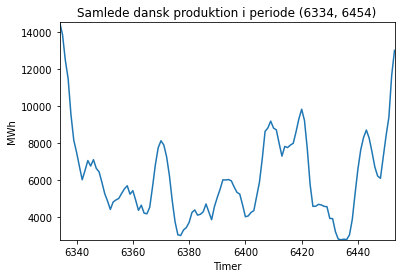

In [14]:
plot(Timer, dk_energy_production, title='Samlede dansk produktion i periode (6334, 6454)', freq=None, start=6334, end=6454)

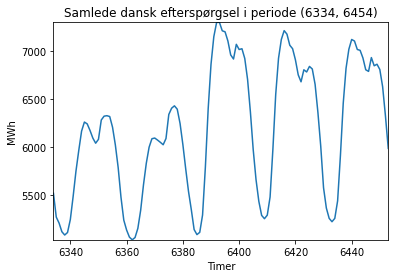

In [15]:
plot(Timer, dk_energy_demand, title='Samlede dansk efterspørgsel i periode (6334, 6454)', freq=None, start=6334, end=6454)

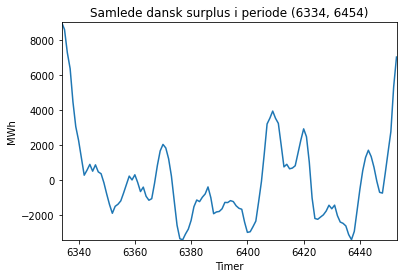

In [16]:
plot(Timer, dk_energy_production-dk_energy_demand, title='Samlede dansk surplus i periode (6334, 6454)', freq=None, start=6334, end=6454)

In [17]:
# Finder hvor meget EENS der er i DK
dk_EENS = np.array([])
for hour in range(6334, 6453 + 1):
    hour_data = Sim.loc[hour]
    total_EENS = (
        hour_data['DK1_EENS']
        + hour_data['DK2_EENS']
        + hour_data['DKBO_EENS']
        + hour_data['DKKF_EENS']
        + hour_data['DKEI_EENS']
    )
    dk_EENS = np.append(dk_EENS, total_EENS)

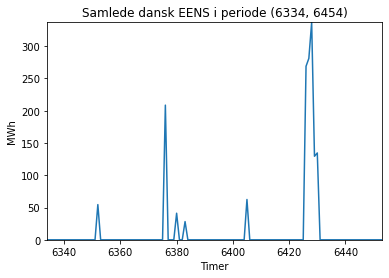

In [18]:
plot(Timer, dk_EENS, title='Samlede dansk EENS i periode (6334, 6454)', freq=None, start=6334, end=6454)

In [19]:
# Finder hvor meget energi produktion der er i DK1 og DK2
DK1_energy_production = np.array([])
for hour in range(6334, 6453 + 1):
    hour_data = Sim.loc[hour]
    total_production_DK1 = (
        hour_data['DK1_ICHP']
        + hour_data['DK1_Wind']
        + hour_data['DK1_Solar']
        + hour_data['DK1_ROR']
        + hour_data['DK1_CKV_BP']
        + hour_data['DK1_CKV_EX']
        + hour_data['DK1_CKV_GT']
        + hour_data['DK1_DKV_CC']
        + hour_data['DK1_DKV_affald']
        + hour_data['DK1_DKV_GM']
        + hour_data['DK1_DKV_bio']
        + hour_data['DK1_CKV_affald']
        + hour_data['DK1_DKV_GT']
        + hour_data['DK1_Regulerkraft']
    )
    DK1_energy_production = np.append(DK1_energy_production, total_production_DK1)
    
DK2_energy_production = np.array([])
for hour in range(6334, 6453 + 1):
    hour_data = Sim.loc[hour]
    total_production_DK2 = (
        hour_data['DK2_ICHP']
        + hour_data['DK2_Wind']
        + hour_data['DK2_Solar']
        + hour_data['DK2_CKV_BP']
        + hour_data['DK2_CKV_EX']
        + hour_data['DK2_KYV22']
        + hour_data['DK2_CKV_GT']
        + hour_data['DK2_DKV_CC']
        + hour_data['DK2_CKV_affald']
        + hour_data['DK2_DKV_bio']
        + hour_data['DK2_DKV_GM']
        + hour_data['DK2_DKV_affald']
        + hour_data['DK2_Regulerkraft']
    )
    DK2_energy_production = np.append(DK2_energy_production, total_production_DK2)

In [20]:
# Finder hvor meget energi demand der er i DK1 og DK2
DK1_energy_demand = np.array([])
for hour in range(6334, 6453 + 1):
    hour_data = Sim.loc[hour]
    total_demand_DK1 = (
        hour_data['DK1_demand']
    )
    DK1_energy_demand = np.append(DK1_energy_demand, total_demand_DK1)
DK2_energy_demand = np.array([])
for hour in range(6334, 6453 + 1):
    hour_data = Sim.loc[hour]
    total_demand_DK2 = (
        hour_data['DK2_demand']
    )
    DK2_energy_demand = np.append(DK2_energy_demand, total_demand_DK2)

In [21]:
# Finder hvor meget EENS der er i DK1 og DK2
DK1_EENS = np.array([])
for hour in range(6334, 6453 + 1):
    hour_data = Sim.loc[hour]
    total_EENS_DK1 = (
        hour_data['DK1_EENS']
    )
    DK1_EENS = np.append(DK1_EENS, total_EENS_DK1)
DK2_EENS = np.array([])
for hour in range(6334, 6453 + 1):
    hour_data = Sim.loc[hour]
    total_EENS_DK2 = (
        hour_data['DK2_EENS']
    )
    DK2_EENS = np.append(DK2_EENS, total_EENS_DK2)

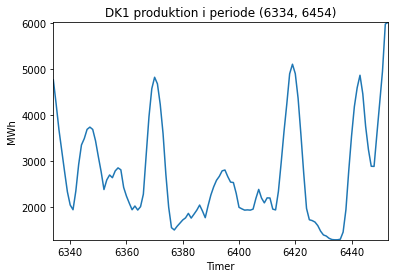

In [22]:
#Plotter de 4 plots for DK1
plot(Timer, DK1_energy_production, title='DK1 produktion i periode (6334, 6454)', freq=None, start=6334, end=6454)

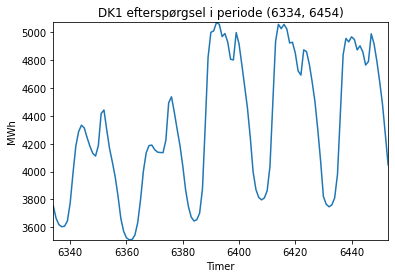

In [23]:
plot(Timer, DK1_energy_demand, title='DK1 efterspørgsel i periode (6334, 6454)', freq=None, start=6334, end=6454)

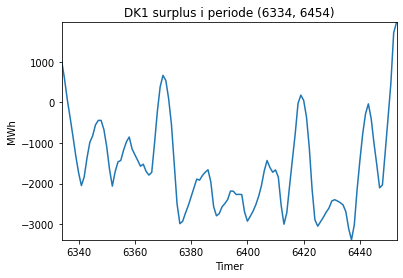

In [24]:
plot(Timer, DK1_energy_production-DK1_energy_demand, title='DK1 surplus i periode (6334, 6454)', freq=None, start=6334, end=6454)

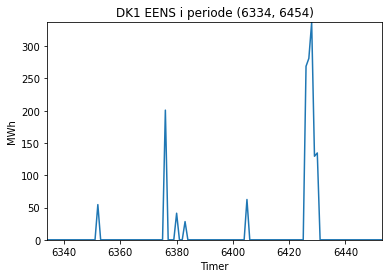

In [25]:
plot(Timer, DK1_EENS, title='DK1 EENS i periode (6334, 6454)', freq=None, start=6334, end=6454)

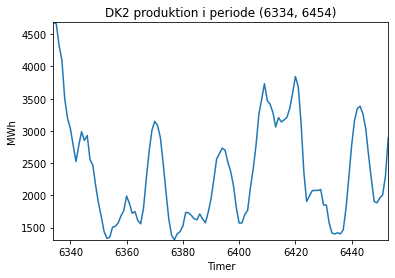

In [26]:
#Plotter de 4 plots for DK2
plot(Timer, DK2_energy_production, title='DK2 produktion i periode (6334, 6454)', freq=None, start=6334, end=6454)

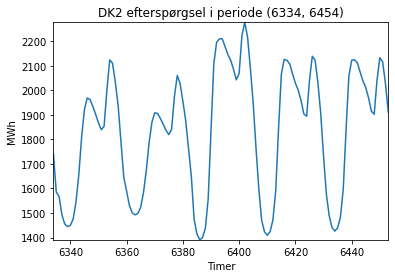

In [27]:
plot(Timer, DK2_energy_demand, title='DK2 efterspørgsel i periode (6334, 6454)', freq=None, start=6334, end=6454)

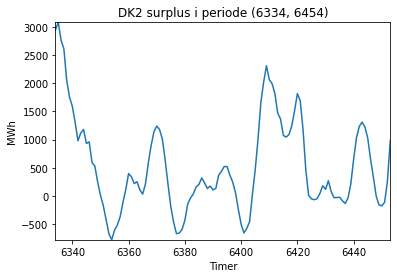

In [28]:
plot(Timer, DK2_energy_production-DK2_energy_demand, title='DK2 surplus i periode (6334, 6454)', freq=None, start=6334, end=6454)

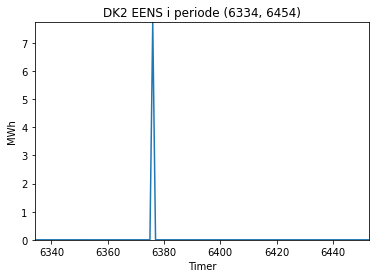

In [29]:
plot(Timer, DK2_EENS, title='DK2 EENS i periode (6334, 6454)', freq=None, start=6334, end=6454)

## Produktion per kilde

In [30]:
#Her defineres de lav produktions perioder som blev fundet i Dataanalyse-2035.ipynb
low_energy = [(805,924),(1290,1409),(1492,1611),(4088,4207),(5425,5544),(6334,6453),(7149,7268),
              (7549,7668),(7758,7877),(8155,8274)]

In [31]:
# finder kolloner der indeholder de nodes. Hvis man ønsker at analysere andre lande skal de først tilføjes her
cols_to_keep = Sim.filter(like='DK1').columns.tolist() + \
               Sim.filter(like='DK2').columns.tolist() + \
               Sim.filter(like='NOs').columns.tolist() + \
               Sim.filter(like='DELU').columns.tolist()

cols_to_keep = [*set(cols_to_keep)]
# subsetter dataframen såde kun indeholder overstående kolloner
Sim_subset = Sim[cols_to_keep]

In [32]:
# sørger for at dataframen kun indeholder lav energi perioderne
low_energy_rows_focus = pd.DataFrame()

for period in low_energy:
    low_energy_rows_focus = pd.concat([low_energy_rows_focus, Sim_subset.loc[period[0]:period[1]]])
#Fjerner duplicates
low_energy_rows_focus = low_energy_rows_focus.loc[:, ~low_energy_rows_focus.columns.duplicated()]

In [33]:
#Her defineres en funktion der plotter produktionen for et givent land.
def plot_stack_production(df, country, period):
    """
    Plotter hver energi produktions kilde for hvert time. det plottes som et stacked bar graph hvor hver produktion
    kilde plottes ovenpå hinanden.

    Parametere:
        df (DataFrame): Den dataframe der indeholder det ønskede datasæt det kan enten være Sim_subset hvis man ønsker
        en generel plot hvor alle timer kan bruges eller det kan være low_energy_rows_focus hvis man ønsker lav
        energi produktions perioderne.
        country (str): Det land der undersøges det kunne f.eks. være 'DK1'
        period (tuple): En periode som er defineret som en tuple (start_hour, end_hour).
    """
    # Definerer energi kilderne som skal plottes
    energy_sources = ['ICHP', 'Wind', 'Solar', 'ROR', 'CKV_BP', 'CKV_EX', 'CKV_GT', 'DKV_CC', 'DKV_affald',
                      'DKV_GM', 'DKV_bio', 'CKV_affald', 'DKV_GT', 'DKV_bio', 'Regulerkraft', 'KYV22', 'CKV_DI',
                      'HydroRes', 'OtherRes', 'OtherNonRes', 'DSR', 'Battery', 'MustRun', 'GasUdland',
                      'NuclearSweden', 'KulUdland', 'OlieUdland', 'HydroPumpCL', 'Borssele', 'Biofuels']

    # Subsetter datasættet så det kun er for den givne periode og land
    subset = df.filter(like=country)
    subset = subset.loc[period[0]:period[1]]

    # Summerer produktion over alle kilder
    production_by_source = {}
    for source in energy_sources:
        production_by_source[source] = subset.filter(like=source).sum().sum()

    # Plotter dataen som et stacked bar graph
    fig, ax = plt.subplots()
    hourly_production = subset.filter(like='ICHP').sum(axis=1).to_frame(name='ICHP')
    hourly_production['Wind'] = subset.filter(like='Wind').sum(axis=1)
    hourly_production['Solar'] = subset.filter(like='Solar').sum(axis=1)
    hourly_production['ROR'] = subset.filter(like='ROR').sum(axis=1)
    hourly_production['CKV_BP'] = subset.filter(like='CKV_BP').sum(axis=1)
    hourly_production['CKV_EX'] = subset.filter(like='CKV_EX').sum(axis=1)
    hourly_production['CKV_GT'] = subset.filter(like='CKV_GT').sum(axis=1)
    hourly_production['DKV_CC'] = subset.filter(like='DKV_CC').sum(axis=1)
    hourly_production['DKV_affald'] = subset.filter(like='DKV_affald').sum(axis=1)
    hourly_production['DKV_GM'] = subset.filter(like='DKV_GM').sum(axis=1)
    hourly_production['DKV_bio'] = subset.filter(like='DKV_bio').sum(axis=1)
    hourly_production['CKV_affald'] = subset.filter(like='CKV_affald').sum(axis=1)
    hourly_production['DKV_GT'] = subset.filter(like='DKV_GT').sum(axis=1)
    hourly_production['DKV_bio'] = subset.filter(like='DKV_bio').sum(axis=1)
    hourly_production['Regulerkraft'] = subset.filter(like='Regulerkraft').sum(axis=1)
    hourly_production['KYV22'] = subset.filter(like='KYV22').sum(axis=1)
    hourly_production['CKV_DI'] = subset.filter(like='CKV_DI').sum(axis=1)
    hourly_production['HydroRes'] = subset.filter(like='HydroRes').sum(axis=1)
    hourly_production['OtherRes'] = subset.filter(like='OtherRes').sum(axis=1)
    hourly_production['OtherNonRes'] = subset.filter(like='OtherNonRes').sum(axis=1)
    hourly_production['DSR'] = subset.filter(like='DSR').sum(axis=1)
    hourly_production['Battery'] = subset.filter(like='Battery').sum(axis=1)
    hourly_production['MustRun'] = subset.filter(like='MustRun').sum(axis=1)
    hourly_production['GasUdland'] = subset.filter(like='GasUdland').sum(axis=1)
    hourly_production['NuclearSweden'] = subset.filter(like='NuclearSweden').sum(axis=1)
    hourly_production['KulUdland'] = subset.filter(like='KulUdland').sum(axis=1)
    hourly_production['OlieUdland'] = subset.filter(like='OlieUdland').sum(axis=1)
    hourly_production['HydroPumpCL'] = subset.filter(like='HydroPumpCL').sum(axis=1)
    hourly_production['Borssele'] = subset.filter(like='Borssele').sum(axis=1)
    hourly_production['Biofuels'] = subset.filter(like='Biofuels').sum(axis=1)

    # Hvis energi kilden har produktion som er non-zero tilføjes de til listen
    non_zero_sources = [source for source in energy_sources if production_by_source[source] > 0]

    # opdaterer hourly_production så den kun indeholder non-zero produktion
    hourly_production = hourly_production[non_zero_sources]

    # laver et stacked bar chart for den nuværende periode og land med det opdaterede dataframe
    hourly_production.plot(kind='bar', stacked=True, ax=ax)

    # Sørger for legenden kun viser non-zero produktion
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 10}, ncol=2, handlelength=1, handleheight=1, labels=non_zero_sources)

    #sætter titler og labels
    ax.set_title(f'{country} ({period[0]}-{period[1]})')
    ax.set_xlabel('Time')
    ax.set_ylabel('Energi produktion (MWh)')
    xticks = range(0, len(hourly_production), 10)
    ax.set_xticks(xticks)

    #Printer plottet
    plt.show()

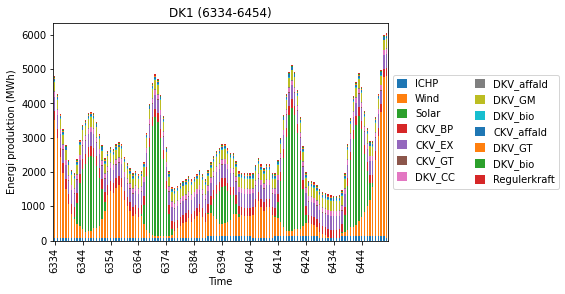

In [34]:
plot_stack_production(low_energy_rows_focus, 'DK1', (6334,6454))

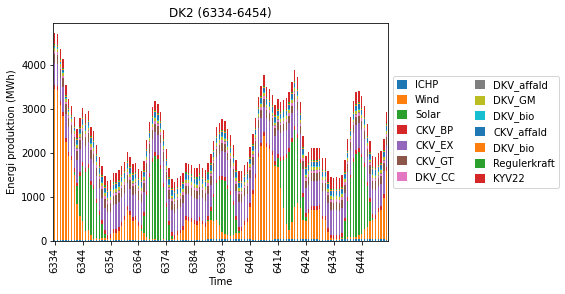

In [35]:
plot_stack_production(low_energy_rows_focus, 'DK2', (6334,6454))

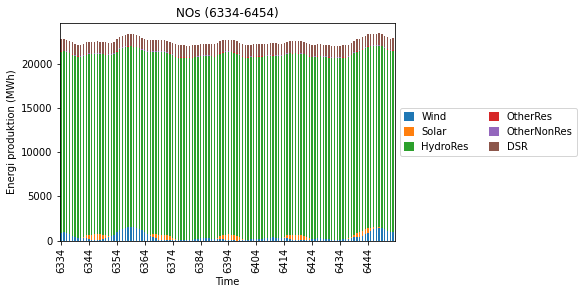

In [36]:
plot_stack_production(low_energy_rows_focus, 'NOs', (6334,6454))

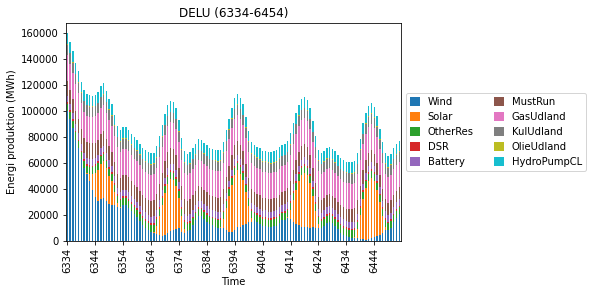

In [37]:
plot_stack_production(low_energy_rows_focus, 'DELU', (6334,6454))

## Import/eksport grafer

In [38]:
# Laver en dataframe der isolere EENS og surplus
pattern_e = re.compile("(.*_EENS|.*_surplus)")
EENS_sur = Sim.filter(regex=pattern_e)

In [39]:
# Nogle af kollonerne i import og eksport delen i resultaterne ser lidt sjovt ud med flere kolloner for et
# et område, dette renses sådan at den energi der sendes DK_1 til DELU og til DELU_1 er det samme
Sim['DK1_to_DELU'] = Sim['DK1_to_DELU'] + Sim['DK1_to_DELU_1']
Sim.drop('DK1_to_DELU_1', axis=1, inplace=True)
Sim['DK2_to_SE4'] = Sim['DK2_to_SE4'] + Sim['DK2_to_SE4_1'] + Sim['DK2_to_SE4_2'] + Sim['DK2_to_SE4_3']
Sim.drop({'DK2_to_SE4_1', 'DK2_to_SE4_2', 'DK2_to_SE4_3'}, axis=1, inplace=True)
Sim['SE3_to_SE4'] = Sim['SE3_to_SE4'] + Sim['SE3_to_SE4_1']
Sim.drop('SE3_to_SE4_1', axis=1, inplace=True)
Sim['DELU_to_BE'] = Sim['DELU_to_BE'] + Sim['DELU_to_BE_1']
Sim.drop('DELU_to_BE_1', axis=1, inplace=True)
Sim['CH_to_IT'] = Sim['CH_to_IT'] + Sim['CH_to_IT_1']
Sim.drop('CH_to_IT_1', axis=1, inplace=True)

In [40]:
# Her finder jeg de kolloner der har et 'to' imellem altså nodes med import eksport
pattern = r'^\w+_to_\w+$' 
Sim_nodes = Sim.filter(regex=pattern)
# Fjerner alt import export med units til sidst
columns_to_remove = [col for col in Sim_nodes.columns if col.endswith("_units")]
Sim_nodes = Sim_nodes.loc[:, ~Sim_nodes.columns.isin(columns_to_remove)]

In [41]:
# sørger for at det kun er nogle bestemte kolloner der er inkluderet i datsættet
nodes = ['DK1', 'DK2', 'NOs', 'DELU']
columns_to_keep = [col for col in Sim_nodes.columns if any(node in col for node in nodes)]
columns_to_keep_e = [col for col in EENS_sur.columns if any(node in col for node in nodes)]
Sim_nodes = Sim_nodes[columns_to_keep]
EENS_sur = EENS_sur[columns_to_keep_e]

In [42]:
#her findes samlede energi import og eksport over perioden
e.print_energy_transfer(Sim_nodes, 'DK1', (6334,6454), EENS_sur)

Period (6334 to 6454)

Total import
DKEI: 32,482.906
DK2: 10,015.689
NOs: 43,898.056
SE3: 31,242.269
DELU: 83,972.188
NL: 9,265.783
GB: 24,476.769
Total import: 235,353.659

Total export
DKEI: 0.000
DK2: 1,522.224
NOs: 8,779.175
SE3: 11,609.452
DELU: 6,297.164
NL: 615.979
GB: 6,131.518
Total export: 34,955.511

Total surplus: -185,816.87. 
Total EENS: 1,537.88. 




In [43]:
#her findes samlede energi import og eksport over perioden
e.print_energy_transfer(Sim_nodes, 'DK2', (6334,6454), EENS_sur)

Period (6334 to 6454)

Total import
DK1: 1,522.224
DKBO: 6,745.288
SE4: 5,607.016
DELU: 3,405.715
DKKF: 2,275.173
Total import: 19,555.416

Total export
DK1: 10,015.689
DKBO: 0.000
SE4: 11,250.874
DELU: 1,261.242
DKKF: 0.000
Total export: 22,527.805

Total surplus: 65,482.53. 
Total EENS: 7.74. 




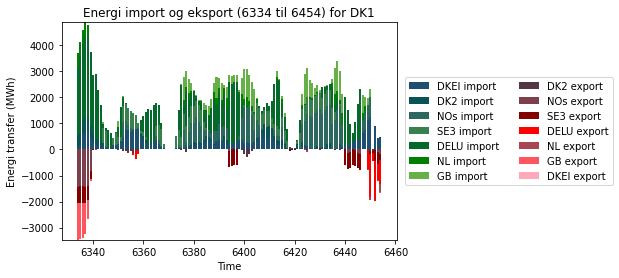

Total surplus: -185,816.87. 
Total EENS: 1,537.88. 


In [44]:
#Et plot der viser det samme som tallene ovenover her kan man se import og eksport for DK1 i den angivne tidsperiode
#hvor grafen er opgjort i origin og destination nodes derudover printes det totale surplus og totale EENS 
#igennem alle 8760 timer. Node kan ændres ved at ændre 'DK1' og perioden kan ændres ved at ændre (6334,6453+1)
e.plot_energy_transfer(Sim_nodes, 'DK1', (6334,6454), EENS_sur)

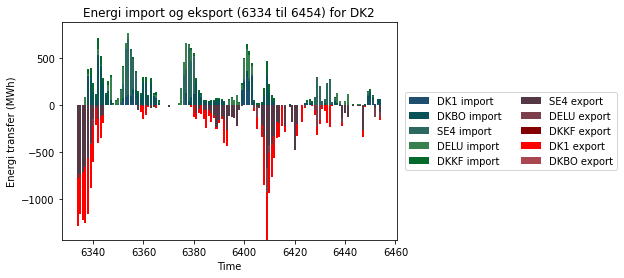

Total surplus: 65,482.53. 
Total EENS: 7.74. 


In [45]:
#Samme plot som over men for 'DK2'
e.plot_energy_transfer(Sim_nodes, 'DK2', (6334,6454), EENS_sur)

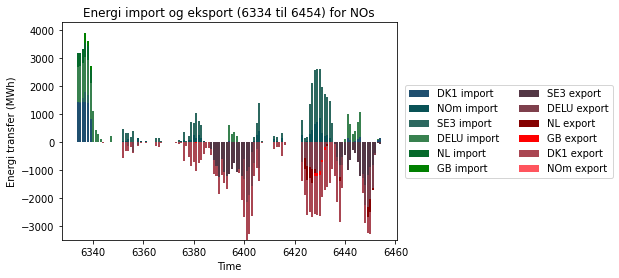

Total surplus: 1,195,613.57. 
Total EENS: 0.00. 


In [46]:
#Samme plot som over men for 'NOs'
e.plot_energy_transfer(Sim_nodes, 'NOs', (6334,6454), EENS_sur)

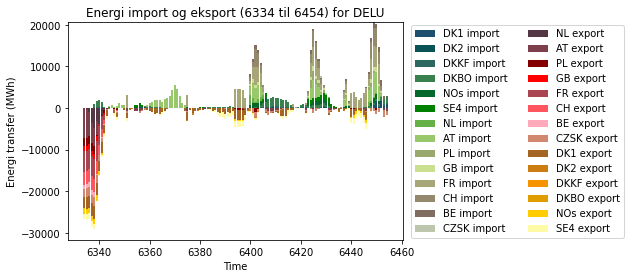

Total surplus: 2,063,035.08. 
Total EENS: 7,684.60. 


In [47]:
#Samme plot som over men for 'DELU'
e.plot_energy_transfer(Sim_nodes, 'DELU', (6334,6454), EENS_sur)

## Netværk graf

In [48]:
# isolere alle område navnene ud fra at de hedder _demand til sidst
nodes = set([col.split('_')[0] for col in Sim.columns if '_demand' in col])

# Looper over hvert "node" eller område
for node in nodes:
    # Finder alle de mulige energi produktioner for hvert område
    production_cols = [col for col in Sim.columns if node in col and any([col.endswith(f'_{prefix}') for prefix in ['ICHP', 'Wind', 'Solar', 'ROR', 'CKV_BP', 'CKV_EX', 'CKV_GT', 'DKV_CC', 'DKV_affald',
                      'DKV_GM', 'DKV_bio', 'CKV_affald', 'DKV_GT', 'DKV_bio', 'Regulerkraft', 'KYV22', 'CKV_DI',
                      'HydroRes', 'OtherRes', 'OtherNonRes', 'DSR', 'Battery', 'MustRun', 'GasUdland',
                      'NuclearSweden', 'KulUdland', 'OlieUdland', 'HydroPumpCL', 'Borssele', 'Biofuels']])]
    # Summer hvert områdes samlede mulige energi produktion
    Sim[node+'_total_production'] = Sim[production_cols].sum(axis=1)

# Fjerner alt import export med units til sidst
columns_to_remove = [col for col in Sim.columns if col.endswith("_units")]
Sim = Sim.loc[:, ~Sim.columns.isin(columns_to_remove)]

In [49]:
# opretter et networkx-graph til at visualisere dataen
G = nx.DiGraph()

# Tilføjer hver område som en node på grafen, nogle koordinater finde geolocatoren andre skal indsættes manuelt
geolocator = Nominatim(user_agent="my-custom-user-agent")
pos = {}
#disse områder skal koordinater indsættes manuelt
manual_positions = {'DKBO': (55.105012, 14.919559), 'DKKF': (54.785718, 13.174180), 'EELVLT': (56.793590, 25.507074), 'DKEI': (54.082111, 5.828569)}
#for hver område findes demand, samlede production og dens koordinater
for node in nodes:
    demand = Sim.loc[:, f'{node}_demand'] 
    production = Sim.loc[:, f'{node}_total_production']
    location = geolocator.geocode(node) #geolocator som finder områdes koordinater
    if location is not None:
        pos[node] = (location.latitude, location.longitude)
    else:
        pos[node] = manual_positions[node]

#Nogle koordinater bliver fundet forkert de bliver også lige opdateret her
pos['NOm'] = (61.327316, 9.662910)
pos['NOs'] = (58.678128, 8.954875)
pos['NOn'] = (68.016139, 15.961278)
pos['NL'] = (52.873970, 5.731174)
pos['DK1'] = (56.082507, 9.020985)
pos['DK2'] = (55.678980, 12.577354)
pos['CZSK'] = (49.864708, 15.376802)
pos['DELU'] = (50.786713, 10.092972)
pos['SE1'] = (67.571040, 21.432379)
pos['SE2'] = (63.948712, 16.970069)
pos['SE3'] = (59.369094, 15.905253)
pos['SE4'] = (56.801952, 13.932221)
pos['ESPT'] = (40.409061, -3.698818)
#alt data om nodes altså demand, production og koordinator tilføjes til networkx-graph
for node in nodes:
    G.add_node(node, demand=demand, production=production, pos=pos)

# Energi overførsel mellem lande bliver tilføjet til networkx-graph
for column in Sim.filter(regex='_to_').columns:
    source, destination = column.split('_to_')
    transfer = Sim[column].sum()
    G.add_edge(source, destination, transfer=transfer)

In [50]:
#vælger nogle random farver til hver node, disse bruges til at visualasierer energi overførsel
node_colors = {}
for node in nodes:
    node_colors[node] = '#' + ''.join(random.choice('0123456789ABCDEF') for _ in range(6))

In [51]:
#Her laves en funktion til at plotte netværket
def plot_network(hour):
    if hour == 'Total':
        # hvis hour er sat til 'Total' så summes der over hele tidsperioden 0-8760
        hour_data = Sim.sum(axis=0)
    elif isinstance(hour, tuple):
        # hvis hour = en tuple (periode der ser sådan ud (start_time, slut_time)) summer den over perioden
        hour_data = Sim.loc[hour[0]:hour[1], :].sum(axis=0)
    else:
        # ellers hvis hour er en enkelt time så finder den alt data for denne ene time
        hour_data = Sim.loc[hour, :]

    # Sørger for kortet er som jeg vil have det ser ud
    map_bounds = {
        'lat_min': 34.5,
        'lat_max': 71.5,
        'lon_min': -10.0,
        'lon_max': 35.0
    }

    # Laver et basemap af europa
    fig = plt.figure(figsize=(128, 80))
    m = Basemap(projection='merc', resolution='l', area_thresh=1000.0,
                llcrnrlon=map_bounds['lon_min'], llcrnrlat=map_bounds['lat_min'],
                urcrnrlon=map_bounds['lon_max'], urcrnrlat=map_bounds['lat_max'])
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary(fill_color='#46bcec')
    m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')

    # Tegner hvert område på kortet
    for node in nodes:
        demand = hour_data[f'{node}_demand']
        production = hour_data[f'{node}_total_production']
        x, y = m(pos[node][1], pos[node][0])
        plt.plot(x, y, 'o', markersize=8, color='#ff0000', alpha=0.8)
        plt.text(x, y+29000, node, fontsize=20, fontweight='bold',
                 ha='center', va='center', color='#000000')

        # Tilføjer demand og produktion labels
        plt.text(x, y+70000, f"Demand: {demand:,.0f} MW", fontsize=20,
                 ha='center', va='center', color='#000000')
        plt.text(x, y-45000, f"Production: {production:,.0f} MW", fontsize=20,
                 ha='center', va='center', color='#000000')

    # Tilføjer energi overførsler
    for column in Sim.filter(regex='_to_').columns:
        source, destination = column.split('_to_')
        transfer_h = hour_data[column].sum()
        G.add_edge(source, destination, transfer=transfer_h)

    # tegner energi overførsler som pile på kortet
    for edge in G.edges(data=True):
        source = edge[0]
        destination = edge[1]
        transfer = edge[2]['transfer']
        x1, y1 = m(pos[source][1], pos[source][0])
        x2, y2 = m(pos[destination][1], pos[destination][0])
        if transfer > 0:
            arrow_dir = 1
        else:
            arrow_dir = -1
            transfer *= -1
            x1, y1, x2, y2 = x2, y2, x1, y1  # Jeg ønsker pilen peger den vej energien bliver overført derfor
            #omvendes koordinaterne
        plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.5, linewidth=2,
                 solid_capstyle='round', zorder=2)
        arrow = patches.FancyArrow(x1, y1, x2-x1, y2-y1, length_includes_head=True, head_width=30000, color=node_colors[source])

        plt.gca().add_patch(arrow)
        arrow_direction = np.sign(x2 - x1)
        if arrow_direction > 0: # pil går mod højre
            text_offset = (-30, 20) # så skal teksten rykkes op
        elif arrow_direction < 0: # pil går mod venstre
            text_offset = (-30, 20) # så skal tekst rykkes op
        elif arrow_direction == 0: # hvis pilen går vertikalt
            text_offset = (-50, 0) # ryk teksten op

        plt.annotate(f"{transfer:,.0f} MW",
                     xy=((x1+x2)/2, (y1+y2)/2), xycoords='data',
                     xytext=text_offset, textcoords='offset points',
                     fontsize=20, ha='center', va='center',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=2),
                     arrowprops=dict(facecolor='black', arrowstyle='-|>', lw=2))

    # Tilføjer en title og printer figuren
    plt.title(f"Electricity Demand, Production, and Transfer in Europe ({hour}h)", fontsize=50)
    return fig

In [52]:
#plot_network((6334,6454))
#plt.tight_layout()
#plt.savefig('Network.jpg', dpi=400, bbox_inches='tight')

## Ti timer med højest EENS

In [53]:
columns_to_keep = [col for col in Sim.columns if "DK1" in col or "DK2" in col]

Sim_DK = Sim[columns_to_keep]

In [54]:
columns_to_drop = [
    'DK1_ICHP', 'DK1_Wind', 'DK1_Solar', 'DK1_ROR', 'DK1_CKV_BP', 'DK1_CKV_EX', 'DK1_CKV_GT', 'DK1_DKV_CC',
    'DK1_DKV_affald', 'DK1_DKV_GM', 'DK1_DKV_bio', 'DK1_CKV_affald', 'DK1_DKV_GT', 'DK1_Regulerkraft',
    'DK2_ICHP', 'DK2_Wind', 'DK2_Solar', 'DK2_CKV_BP', 'DK2_CKV_EX', 'DK2_KYV22', 'DK2_CKV_GT', 'DK2_DKV_CC',
    'DK2_CKV_affald', 'DK2_DKV_bio', 'DK2_DKV_GM', 'DK2_DKV_affald', 'DK2_Regulerkraft', 'DK1_varSurplus',
    'DK2_varSurplus', 'DK1_plannedOutage', 'DK2_plannedOutage','DK1_unplannedOutage', 'DK2_unplannedOutage',
    'DK1_EUE', 'DK2_EUE', 'DK1_to_DK2', 'DK1_to_NOs', 'DK1_to_SE3', 'DK1_to_DELU', 'DK1_to_NL', 'DK1_to_GB', 'DK2_to_SE4', 'DK2_to_DELU', 'DK2_to_DKKF', 'DKEI_to_DK1',
    'DKBO_to_DK2'
]

Sim_DK = Sim_DK.drop(columns=columns_to_drop)

In [55]:
desired_column_order = [
    'DK1_demand', 'DK1_total_production', 'DK1_surplus', 'DK1_netImport', 'DK1_EENS', 'DK2_demand', 'DK2_total_production', 'DK2_surplus',
    'DK2_netImport', 'DK2_EENS'
]

Sim_DK = Sim_DK.reindex(columns=desired_column_order)

In [62]:
Sim_DK['total_eens']=Sim_DK['DK1_EENS']+Sim_DK['DK2_EENS']
Sim_DK = Sim_DK.sort_values(by='total_eens', ascending=False)

Sim_DK_top_10 = Sim_DK.head(10)

Sim_DK_top_10 = Sim_DK_top_10.drop('total_eens', axis=1)
Sim_DK_top_10 = Sim_DK_top_10.round(2)
Sim_DK_top_10 = Sim_DK_top_10.rename(columns={'DK1_total_production': 'DK1_totprod'})
Sim_DK_top_10 = Sim_DK_top_10.rename(columns={'DK2_total_production': 'DK2_totprod'})

In [64]:
Sim_DK_top_10

,DK1_demand,DK1_totprod,DK1_surplus,DK1_netImport,DK1_EENS,DK2_demand,DK2_totprod,DK2_surplus,DK2_netImport,DK2_EENS
hour,,,,,,,,,,
1266,4912.42,1744.74,-3167.67,3167.67,0.00,3305.86,1361.66,-1944.20,394.68,1549.52
1265,5110.03,1680.80,-3429.23,3326.23,103.00,3149.75,1356.48,-1793.27,437.91,1355.36
1264,5284.97,1599.52,-3685.45,3508.45,177.00,2929.64,1364.86,-1564.78,334.81,1229.96
1267,4718.70,1934.40,-2784.29,2784.30,0.00,3273.54,1368.63,-1904.91,673.19,1231.72
8249,5085.23,1359.88,-3725.35,3315.83,409.52,2799.88,1488.41,-1311.47,749.70,561.77
8248,5310.32,1387.07,-3923.26,3410.93,512.33,2605.21,1506.23,-1098.97,700.41,398.56
8247,5463.27,1431.24,-4032.03,3422.93,609.10,2521.24,1545.50,-975.74,737.60,238.14
7840,5108.82,1817.69,-3291.13,3227.26,63.87,2551.51,1213.59,-1337.92,596.70,741.23
7841,4848.10,1853.23,-2994.86,2994.86,0.00,2727.05,1219.64,-1507.42,740.60,766.82
